In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [128]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers -> no tt

In [129]:
pp_class = pp_class[pp_class["outlier_no_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_no_type"] != True]

### Preprocessing delle variabili

Elimino righe videogame

In [130]:
pp_class = pp_class[pp_class['titleType'] != 'videoGame']
pp_class[['originalTitle', 'titleType']].head(15)

pp_test_class = pp_test_class[pp_test_class['titleType'] != 'videoGame']

Mapping variabile target

In [131]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

Conversione CanHaveEpisodes in binaria 0/1 

In [132]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [133]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

BINARIZZAZIONE -> TOTALmEDIA E TOTALnOM

In [134]:

#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


Encoding di titletype per multiclass classification task

In [135]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

## Gestione features e normalizzazioni

In [136]:


num_log_cols = [
    'totalCredits', 
    'numRegions', 
    'criticReviewsTotal',
       'userReviewsTotal', 
    # 'numVotes',
]

other_num_cols = [
    'rating',
    'runtimeMinutes_notitletype',
    'startYear',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA', 
    #'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK',
]

no_num_cols = [
    #'canHaveEpisodes',  #AIUTA TROPPO
    'totalMedia_bin',
    #'totalNominations_bin'
]

# --- Log transform and scale for num_cols ---
scaler_num = StandardScaler()
X_train_log_scaled_num = pd.DataFrame(
    scaler_num.fit_transform(np.log1p(pp_class[num_log_cols])),
    columns=num_log_cols,
    index=pp_class.index
)
X_test_log_scaled_num = pd.DataFrame(
    scaler_num.transform(np.log1p(pp_test_class[num_log_cols])),
    columns=num_log_cols,
    index=pp_test_class.index
)

# --- Only scale for other_cols ---
scaler_other = StandardScaler()
X_train_scaled_other = pd.DataFrame(
    scaler_other.fit_transform(pp_class[other_num_cols]),
    columns=other_num_cols,
    index=pp_class.index
)
X_test_scaled_other = pd.DataFrame(
    scaler_other.transform(pp_test_class[other_num_cols]),
    columns=other_num_cols,
    index=pp_test_class.index
)


# --- Mantieni le altre colonne invariate ---
X_train_no_scaled = pp_class[no_num_cols]
X_test_no_scaled = pp_test_class[no_num_cols]

# --- Unisci ---
X_train_temp = pd.concat([X_train_log_scaled_num, X_train_scaled_other, X_train_no_scaled], axis=1)
X_test_temp = pd.concat([X_test_log_scaled_num, X_test_scaled_other, X_test_no_scaled], axis=1)

# --- Ricostruisci l'ordine originale delle colonne ---
original_cols = [col for col in pp_class.columns if col in num_log_cols + other_num_cols + no_num_cols]
X_train_tr = X_train_temp[original_cols]
X_test_tr = X_test_temp[original_cols]


In [137]:
X_train2_tr, X_val_tr, y_train2, y_val = train_test_split(
     X_train_tr, y_train, test_size=0.2, random_state=32)

## NAIVE BAYES

In [138]:
clf = GaussianNB()

In [139]:
clf.fit(X_train2_tr, y_train2)

GaussianNB()

### Predicting on validation set

In [140]:
y_pred = clf.predict(X_val_tr)
y_pred

array([2, 0, 0, ..., 0, 7, 7], dtype=int64)

In [141]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3157
3157


In [142]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 4, 5, 6, 7}


In [143]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.664554957237884

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       952
           1       0.80      0.80      0.80      1072
           2       0.46      0.31      0.37       268
           3       0.00      0.00      0.00        26
           4       0.74      0.78      0.76       470
           5       0.11      0.03      0.04       179
           6       0.50      0.03      0.06        31
           7       0.43      0.32      0.37       159

    accuracy                           0.66      3157
   macro avg       0.45      0.38      0.38      3157
weighted avg       0.63      0.66      0.64      3157



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[2.08735476e-02, 3.60335455e-01, 4.47598882e-01, ...,
        4.08895929e-02, 9.74687312e-05, 6.33612569e-05],
       [4.53584292e-01, 1.00042920e-01, 1.45993306e-01, ...,
        9.59806389e-02, 5.36419975e-02, 5.21507736e-02],
       [8.91478994e-01, 4.20810632e-03, 5.63611204e-02, ...,
        6.31464463e-03, 3.13915758e-02, 6.08019193e-03],
       ...,
       [9.45599919e-01, 2.32535480e-06, 2.45462166e-03, ...,
        1.67727606e-03, 4.28234422e-03, 1.14932592e-02],
       [3.57436775e-01, 5.77726748e-04, 1.02772588e-04, ...,
        3.15600480e-02, 2.64919783e-03, 6.07618763e-01],
       [4.35917861e-03, 2.37496540e-02, 1.66029150e-04, ...,
        3.21079496e-01, 1.66193697e-01, 4.84444186e-01]])

roc test

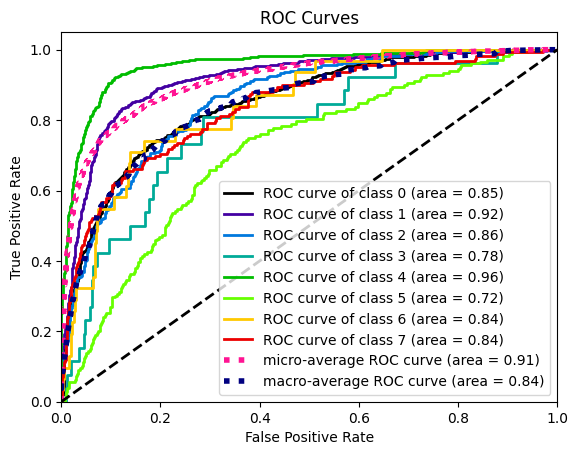

0.8442834102183809


In [145]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.6495
F1 Score: 0.6269

Performance sul Validation set:
Accuracy: 0.6646
F1 Score: 0.6392


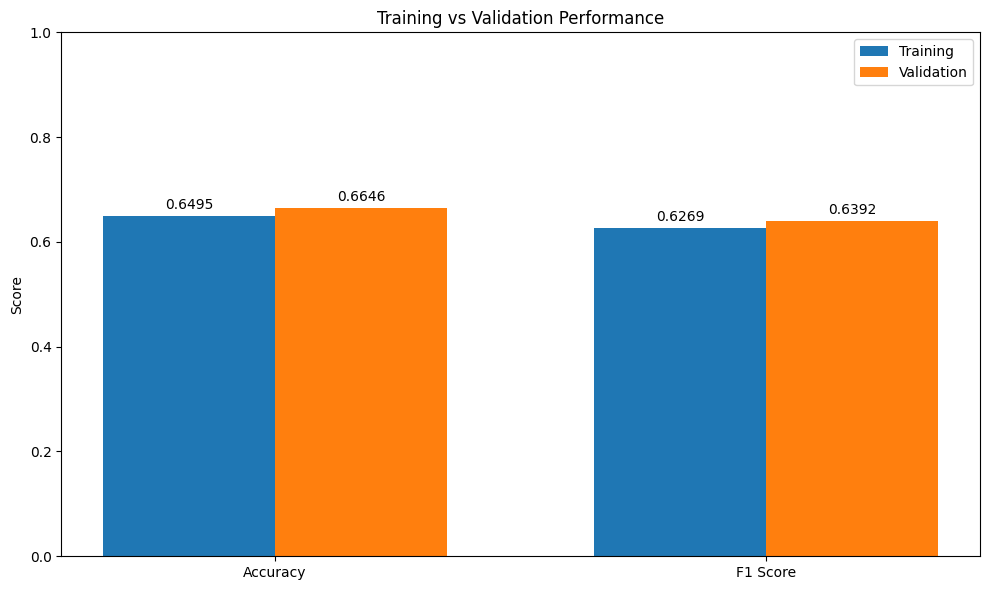

In [146]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [147]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3738
1    4370
2    1069
3     160
4    1912
5     665
6     127
7     585
Name: count, dtype: int64


confusion matrix 

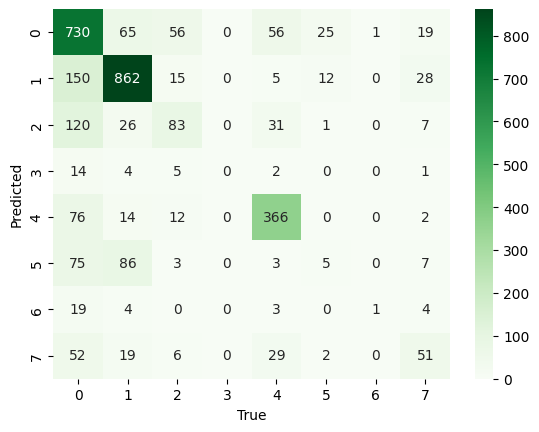

In [148]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Proper testing on the test set

In [149]:
clf = GaussianNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred
# era y_tpred

array([4, 1, 0, ..., 1, 2, 4], dtype=int64)

In [150]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_test))  

5246
5246


Performance sul Training set:
Accuracy: 0.6518
F1 Score: 0.6290

Performance sul test set:
Accuracy: 0.6601
F1 Score: 0.6359


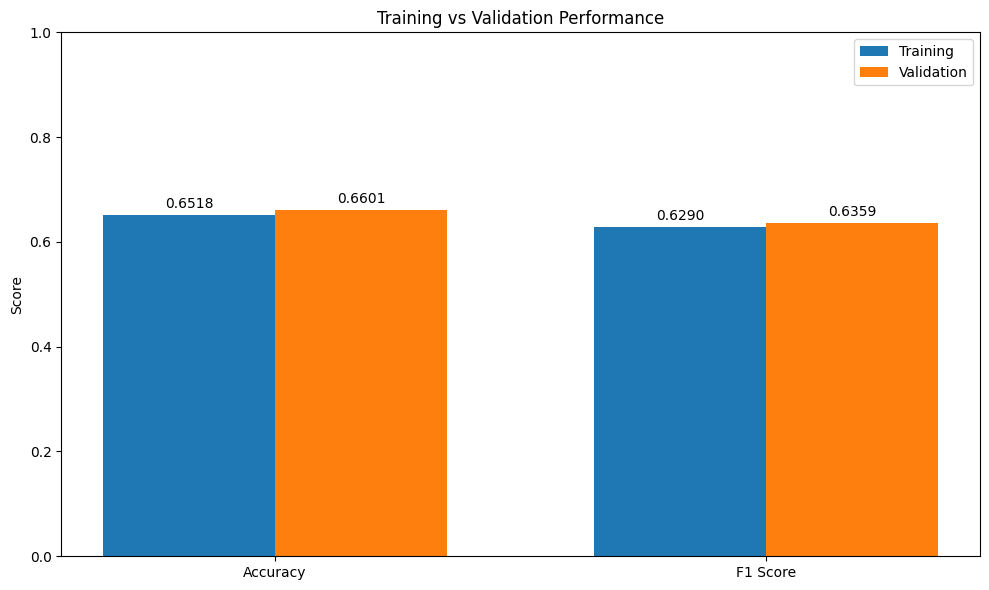

In [151]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [152]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.6601219977125429

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1596
           1       0.80      0.78      0.79      1848
           2       0.45      0.29      0.35       437
           3       0.00      0.00      0.00        68
           4       0.72      0.82      0.77       728
           5       0.10      0.03      0.05       288
           6       0.00      0.00      0.00        42
           7       0.36      0.31      0.33       239

    accuracy                           0.66      5246
   macro avg       0.38      0.37      0.37      5246
weighted avg       0.62      0.66      0.64      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


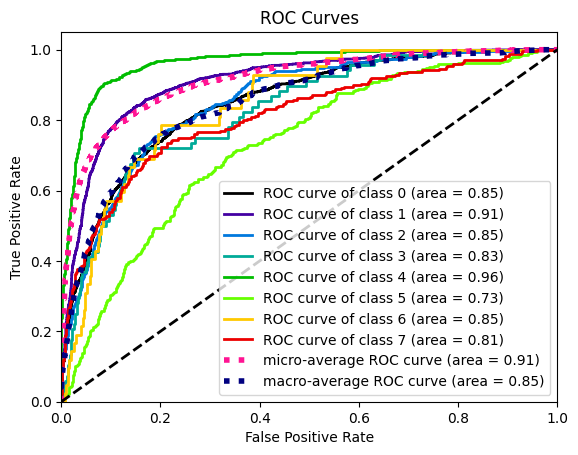

In [153]:
y_test_pred_proba = clf.predict_proba(X_test_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_test_pred_proba)
plt.show()

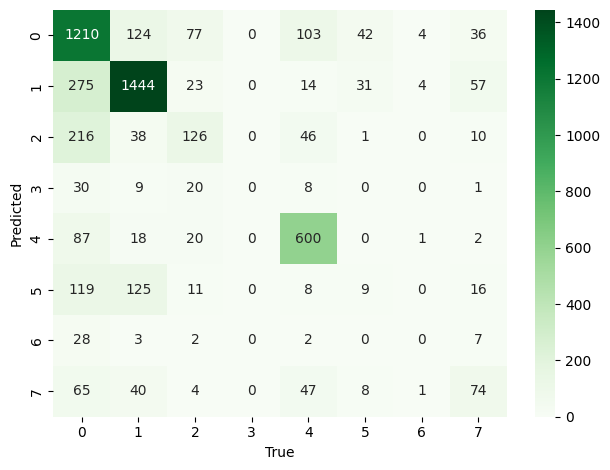

In [154]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Dummy classifier 

In [155]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3522683949675944
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1596
           1       0.35      1.00      0.52      1848
           2       0.00      0.00      0.00       437
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       728
           5       0.00      0.00      0.00       288
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       239

    accuracy                           0.35      5246
   macro avg       0.04      0.12      0.07      5246
weighted avg       0.12      0.35      0.18      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
